In [23]:
import xarray as xr
import numpy as np
from math import nan
import matplotlib.pyplot as plt

from qtrendutils import linfit_utils as linfit
from qtrendutils import mapplot_utils as maps
from qtrendutils import colorbar_utils as cbars

import importlib
importlib.reload(maps)
import sys

In [24]:
dat = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/OBS/vaporpressures/vaporpressures_ISD_fromhourly_ge4pd.nc")
dat = dat.sel(time=slice("1980-01","2020-12"))

# drop stations that have more than 48 months with more than 15 bad days
dropstations=[]
for istation in np.arange(0,dat.station.size,1):
    test = dat.nbaddays.isel(station=istation)
    test = test.where( test > 14, drop=True)
    if (test.size >= 48):
        badstation = np.array_str(dat.station.isel(station=istation).values)
        dropstations.append(badstation)
        
dat = dat.drop_sel(station=dropstations)

In [25]:
### Calculate the annual mean and drop the stations that don't have any data in a year.for vp
dat_am = dat.groupby('time.year').mean('time', skipna=True)
dat_clim = dat_am.mean('year', skipna=False)
dat = dat.where( ~np.isnan(dat_clim.vp), drop=True)

### Check the initial stations

In [26]:
dat_am = dat.vp.groupby('time.year').mean('time', skipna=True)

In [27]:
isdtrends = xr.apply_ufunc(linfit.compute_slope, dat_am, vectorize=True, input_core_dims=[['year']])*dat_am.year.size

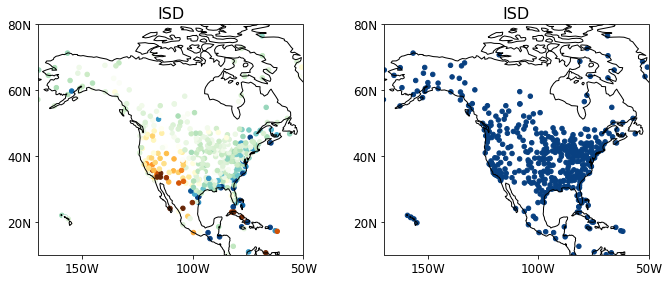

In [30]:
fig = plt.figure(figsize=(16,16))

ax = maps.contourmap_northamerica_scatter_pos(fig, np.array(isdtrends), np.array(dat.lons), np.array(dat.lats),0.1,-2,2,'ISD',
                                                   0.05,0.28,0.77,0.97, cmap="precip")

ax = maps.contourmap_northamerica_scatter_pos(fig, dat.lons*0 + 1, dat.lons, dat.lats, 0.1, -1, 1, 'ISD',
                                              0.35,0.58,0.77,0.97,cmap='precip')

### Read in the shapefile and grab out the US stations

In [7]:
### Flip the lons to go from -180 to 180
newlons = xr.where(dat['lons'] > 180, dat['lons'] - 360, dat['lons'])
dat['lons'] = newlons

In [8]:
dat = dat.load()

In [ ]:
import geopandas as gp
from shapely.geometry import Point

#---First narrow it down by chopping out the longitudes
dat = dat.where( (dat.lons > -150) & (dat.lons < -50), drop=True)
dat = dat.where( (dat.lats > 20) & (dat.lats < 60), drop=True)

shpfile="/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/shp/gadm36_USA_0.shp"
shpcontents = gp.read_file(shpfile)
inus=[]
for i in np.arange(0,dat.lons.size,1):
    print(i)
    inus.append(shpcontents.contains(Point(dat.lons[i], dat.lats[i]))[0])
    
indices = np.argwhere(inus)
datus = dat.isel(station=indices[:,0])

### Only use CONUS i.e., omit Alaska for working out the Voronoi volumes

In [10]:
conusloc=np.argwhere(np.array(datus.lats) < 55)[:,0]
datconus = datus.isel(station=conusloc)

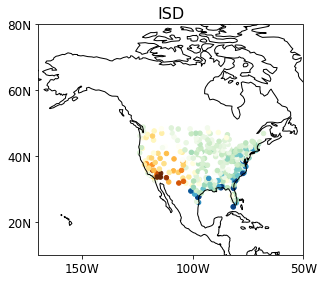

In [11]:
fig = plt.figure(figsize=(16,16))

datconus_am = datconus.groupby('time.year').mean('time')
isdtrends = xr.apply_ufunc(linfit.compute_slope, datconus_am, vectorize=True, input_core_dims=[['year']])*datconus_am.year.size

ax = maps.contourmap_northamerica_scatter_pos(fig, np.array(isdtrends.vp), np.array(datconus.lons), np.array(datconus.lats),0.1,-2,2,'ISD',
                                                   0.05,0.28,0.77,0.97, cmap="precip")

### Work out the voronoi volumes

In [12]:
from scipy.spatial import Voronoi, ConvexHull

def voronoi_volumes(points):
    v = Voronoi(points)
    vol = np.zeros(v.npoints)
    for i, reg_num in enumerate(v.point_region):
        indices = v.regions[reg_num]
        if -1 in indices: # some regions can be opened
            vol[i] = np.inf
        else:
            vol[i] = ConvexHull(v.vertices[indices]).volume
    return vol

vol = voronoi_volumes(np.vstack((datconus.lons, datconus.lats)).T)

### Set the stations that have infinite weights to the maximum weight of the other stations (some don't connect because the sea is there)

In [13]:
area_weights = vol
sorted_vals = np.sort(area_weights)

infvalssort = np.argwhere(np.isinf(sorted_vals))
infvals = np.argwhere(np.isinf(area_weights))
area_weights[infvals] = sorted_vals[infvalssort[0]-1]

### Now grab out the 6 state region

In [14]:
shpfilestates="/project/cas/islas/shapefiles/usa/gadm36_USA_1.shp"

import geopandas as gp
shpcontents = gp.read_file(shpfilestates)

states=['California','Colorado','Utah','Nevada','New Mexico','Arizona']
region = shpcontents[shpcontents.NAME_1 == states[0]]
for i in np.arange(1,len(states),1):
    region = region.append(shpcontents[shpcontents.NAME_1 == states[i]])
    
insw=[]
for i in np.arange(0,datconus.lons.size,1):
    insw.append(any(region.contains(Point(datconus.lons[i], datconus.lats[i]))))
    
# grab out the SW stations
indices = np.argwhere(insw)
datsw = datconus.isel(station=indices[:,0])
area_weightsw = area_weights[indices[:,0]]

In [15]:
### Dealing with weights that are too large because they aren't bounded because they're on the coast.
### If the weights are larger than 15 then I'm setting them to the next lowest maximum
area_weightswnew = np.where(area_weightsw < 15, area_weightsw, nan)
area_weightswnew = np.where(np.isnan(area_weightswnew), np.nanmean(area_weightswnew), area_weightsw)

In [ ]:
### Drop stations that have a NaN for any month
### Not doing this anymore because I'm going to deseasonalize before calculating annual means
#dropstat=[]
#for istat in np.arange(0,datsw.station.size,1):
#    test = datsw.svp.isel(station=istat).sum(skipna=False)
#    print(test.values)
#    if (np.isnan(test)):
#print('dropping')
#        dropstat.append(np.array_str(datsw.station.isel(station=istat).values))

### Check the southwest region and the weights

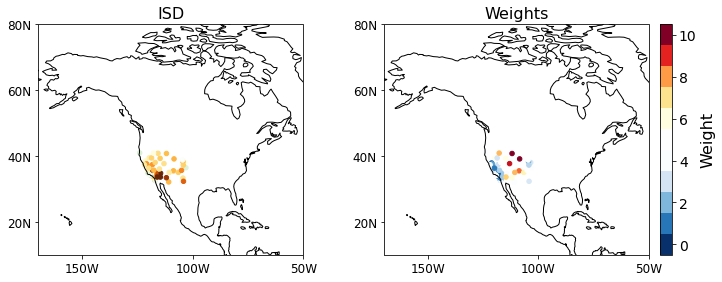

In [16]:
fig = plt.figure(figsize=(16,16))

datsw_am = datsw.groupby('time.year').mean('time')
isdtrends = xr.apply_ufunc(linfit.compute_slope, datsw_am, vectorize=True, input_core_dims=[['year']])*datsw_am.year.size

ax = maps.contourmap_northamerica_scatter_pos(fig, np.array(isdtrends.vp), np.array(datsw.lons), np.array(datsw.lats),0.1,-2,2,'ISD',
                                                   0.05,0.28,0.77,0.97, cmap="precip")

ax = maps.contourmap_northamerica_scatter_pos(fig, np.array(area_weightswnew), np.array(datsw.lons), np.array(datsw.lats),1,0,10,'Weights',
                                             0.35,0.58,0.77,0.97)

ax = cbars.plotcolorbar(fig, 1,0,10,'Weight',0.59,0.6,0.77,0.97,ticks=[0,2,4,6,8,10,12], orient='vertical')


### Assign the weights

In [17]:
area_weightswnew = xr.DataArray(area_weightswnew, coords=[datsw.station], dims=['station'], name='area_weights')

# set the weights to zero for months when there are NaNs
#area_weightswnew_expanded = area_weightswnew.expand_dims({'time':datsw.time}, axis=1)
#area_weightswnew_expanded = area_weightswnew_expanded.where( ~np.isnan(datsw.vp), 0)
#datsw = datsw.assign(area_weights = area_weightswnew_expanded)

datsw = datsw.assign(area_weights = area_weightswnew)

In [44]:
#datsw = datsw.assign(area_weights = area_weightswnew)

In [28]:
#!!! Not doing this anymore
#datsw = datsw.drop_sel(station=dropstat)
#area_weightswnew = area_weightswnew.drop_sel(station=dropstat)

In [18]:
vp_sw = (datsw.vp*datsw.area_weights).sum('station') / np.sum(datsw.area_weights)
vp_sw = vp_sw.rename('vp')
vpd_sw = (datsw.vpd*datsw.area_weights).sum('station') / np.sum(datsw.area_weights)
vpd_sw = vpd_sw.rename('vpd')
svp_sw = (datsw.svp*datsw.area_weights).sum('station') / np.sum(datsw.area_weights)
svp_sw = svp_sw.rename('svp')
relhum_sw = (datsw.relhum*datsw.area_weights).sum('station') /np.sum(datsw.area_weights)
relhum_sw = relhum_sw.rename('relhum')

In [19]:
swavgs = xr.merge([vp_sw, vpd_sw, svp_sw, relhum_sw])

In [20]:
swavgs.to_netcdf("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/vaporpressures/vaporpressures_ISD_USSW_fromhourly_ge4pd.nc")

In [22]:
datsw.to_netcdf("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/vaporpressures/vaporpressures_ISD_USSW_fromhourly_ge4pd_swstations.nc")